In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = keras.datasets.cifar10.load_data()
X_train,X_test = X_train/255,X_test/255
Y_train = keras.utils.to_categorical(Y_train, num_classes=10)
Y_test = keras.utils.to_categorical(Y_test, num_classes=10)

In [33]:
class CapsuleConv2D(keras.layers.Layer):
    
    def __init__(self, channels, kernel_size, strides=(1,1),
                 em_steps=3, temp_start=1., temp_end=1/3.,
                 mat_size=(4,4), coord=False, **kwargs):
        self.channels = channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.em_steps = em_steps
        self.temp_start = temp_start
        self.temp_end = temp_end
        self.mat_size = mat_size
        self.coord = coord
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(self.kernel_size[0]*self.kernel_size[1]*input_shape[0][3],
                   self.channels, *self.mat_size),
            initializer=keras.initializers.TruncatedNormal(
                mean=0., stddev=1.), name='kernel')
        self.beta_a = self.add_weight(
            shape=(self.channels,),
            initializer='zeros', name='beta_a')
        self.beta_u = self.add_weight(
            shape=(self.channels,),
            initializer='zeros', name='beta_u')
        super().build(input_shape)
    
    def call(self, inputs):
        input_shape = [i_.shape for i_ in inputs]
        
        poses, activations = inputs
        input_channel_size = poses.shape[3]
        
        if self.coord:
            coord_y = np.linspace(-1, 1, num=int(poses.shape[1]))
            coord_y = np.repeat(coord_y[:,np.newaxis],int(poses.shape[2]),axis=1)
            coord_x = np.linspace(-1, 1, num=int(poses.shape[2]))
            coord_x = np.repeat(coord_x[np.newaxis,:],int(poses.shape[1]),axis=0)
            coord = np.zeros((1,int(poses.shape[1]),int(poses.shape[2]),
                1,int(poses.shape[4]),int(poses.shape[5])))
            coord[:,:,:,0,0,-1] = coord_x
            coord[:,:,:,0,1,-1] = coord_y
            poses = poses + K.constant(coord)
        
        poses = K.reshape(poses, (
            -1,*poses.shape[1:3],poses.shape[3]*self.mat_size[0]*self.mat_size[1]))
        def conv_expand(x):
            conv_data_size = x.shape[3]
            conv_kernel = np.zeros((*self.kernel_size, conv_data_size,
                                    self.kernel_size[0]*self.kernel_size[1]))
            for i in range(self.kernel_size[0]):
                for j in range(self.kernel_size[1]):
                    conv_kernel[i,j,:,i*self.kernel_size[0]+j] = 1
            x = K.depthwise_conv2d(x, K.constant(conv_kernel),
                                       strides=self.strides, padding='same')
            x = K.reshape(x, (-1,*x.shape[1:3],conv_data_size,
                                     self.kernel_size[0]*self.kernel_size[1]))
            x = K.permute_dimensions(x, (0,1,2,4,3))
            return x
        poses = conv_expand(poses)
        activations = conv_expand(activations)
        
        poses = K.reshape(poses, (-1,*poses.shape[1:3],
            self.kernel_size[0]*self.kernel_size[1]*input_channel_size,
            1,*self.mat_size))
        poses = K.tile(poses, (1,1,1,1,self.channels,1,1))
        kernel = K.reshape(self.kernel, (1,1,1,*self.kernel.shape))
        kernel = K.tile(kernel, K.concatenate([
            K.shape(poses)[:3],K.constant(np.ones((4,)),dtype='int32')]))
        votes = poses @ kernel
        votes = K.reshape(votes, (
            -1,*votes.shape[1:5],self.mat_size[0]*self.mat_size[1]))
        
        activations = K.reshape(activations, (-1,*activations.shape[1:3],
            self.kernel_size[0]*self.kernel_size[1]*input_channel_size,1))
        r = K.constant(1/self.channels, shape=(1,*votes.shape[1:5]))
        r = K.tile(r, K.concatenate([
            K.shape(votes)[:1],K.constant(np.ones((4,)),dtype='int32')]))
        for t in range(self.em_steps):
            inv_temp = self.temp_start*(1-(t/max(1,self.em_steps-1)))
            inv_temp = inv_temp + self.temp_end*(t/max(1,self.em_steps-1))
            inv_temp = 1/inv_temp
            r = r * activations
            r_expanded = K.expand_dims(r)
            r_sum_i = K.expand_dims(K.sum(r, axis=3))
            mu = K.sum(r_expanded*votes,axis=3)/r_sum_i
            mu_diff_square = K.square(votes-K.expand_dims(mu,axis=3))
            mu_diff_square = mu_diff_square + K.epsilon()
            sigma_square = K.sum(r_expanded*mu_diff_square,axis=3)/r_sum_i
            sigma = K.sqrt(sigma_square)
            cost = K.reshape(self.beta_u,(1,1,1,self.channels,1))
            cost = cost + K.log(sigma)
            cost = cost * r_sum_i
            cost_all_h = K.sum(cost,axis=-1)
            # for numerical stability, change cost_all_h to a relative way
            cost_all_h_mu = K.mean(cost_all_h,axis=-1,keepdims=True)
            cost_all_h_sigma = K.var(cost_all_h,axis=-1,keepdims=True)
            cost_all_h_sigma = cost_all_h_sigma + K.epsilon()
            cost_all_h = (cost_all_h - cost_all_h_mu)
            cost_all_h = cost_all_h / cost_all_h_sigma
            a = K.sigmoid(inv_temp*(self.beta_a-cost_all_h))
            if t+1 == self.em_steps: continue
            # for numerical stability, change p from the paper to log p
            log_p = mu_diff_square/K.expand_dims(2*sigma_square,axis=3)
            log_p = -K.sum(log_p,axis=-1)
            log_p = log_p - K.expand_dims(
                K.sum((np.log(2*np.pi)/2)+K.log(sigma),axis=-1),axis=3)
            # for numerical stability, compute r from log p instread of p
            r = K.expand_dims(K.log(a+K.epsilon()),axis=3) + log_p
            r = K.softmax(r,axis=-1)
        
        a = K.print_tensor(a)
        return [K.reshape(mu,(-1,*mu.shape[1:4],*self.mat_size)), a]
    
    def compute_output_shape(self, input_shape):
        return [(input_shape[0][0],
                input_shape[0][1]//self.strides[0],
                input_shape[0][2]//self.strides[1],self.channels,*self.mat_size),(
                input_shape[1][0],
                input_shape[1][1]//self.strides[0],
                input_shape[1][2]//self.strides[1],self.channels)]

In [15]:
def spread_loss(y_true, y_pred):
    m = K.max(y_true)
    y_true = y_true / m
    y_true = K.print_tensor(y_true)
    y_pred = K.print_tensor(y_pred)
    at = K.sum(y_true*y_pred, axis=-1, keepdims=True)
    ad = K.square(K.clip(m - (at - y_pred), 0, None))
    ad = ad * (1-y_true)
    return K.mean(K.sum(ad, axis=-1))

In [5]:
X = X_input = keras.layers.Input(X_train.shape[1:])
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Conv2D(8, (5,5), strides=(2,2), padding='same',
                        activation='relu', kernel_initializer='he_normal')(X)
X = keras.layers.Conv2D(64, (5,5), strides=(1,1), padding='same',
                        activation='relu', kernel_initializer='he_normal')(X)
X_pose = keras.layers.Conv2D(4*4**2, (1,1), padding='same')(X)
X_pose = keras.layers.Lambda(
    lambda x: K.reshape(x, (-1,*x.shape[1:3],4,4,4)),
    output_shape=(int(X_pose.shape[1]),int(X_pose.shape[2]),4,4,4))(X_pose)
X = keras.layers.Conv2D(4, (1,1), padding='same', activation='sigmoid')(X)
X_pose,X = CapsuleConv2D(4, (3,3), strides=(2,2))([X_pose,X])
X_pose,X = CapsuleConv2D(4, (3,3), strides=(2,2), coord=True)([X_pose,X])
X_pose,X = CapsuleConv2D(8, (3,3), strides=(2,2))([X_pose,X])
X_pose,X = CapsuleConv2D(Y_train.shape[-1], (3,3), strides=(2,2))([X_pose,X])
X = keras.layers.Flatten()(X)
M = keras.Model(X_input, X)
M.compile('nadam', spread_loss)
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 8)    608         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   12864       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [34]:
X = X_input = keras.layers.Input(X_train.shape[1:])
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Conv2D(8, (5,5), strides=(2,2), padding='same',
                        activation='relu', kernel_initializer='he_normal')(X)
X = keras.layers.Conv2D(64, (5,5), strides=(1,1), padding='same',
                        activation='relu', kernel_initializer='he_normal')(X)
X_pose = keras.layers.Conv2D(4*4**2, (1,1), padding='same')(X)
X_pose = keras.layers.Lambda(
    lambda x: K.reshape(x, (-1,*x.shape[1:3],4,4,4)),
    output_shape=(int(X_pose.shape[1]),int(X_pose.shape[2]),4,4,4))(X_pose)
X = keras.layers.Conv2D(4, (1,1), padding='same', activation='sigmoid')(X)
X_pose,X = CapsuleConv2D(4, (3,3), strides=(2,2))([X_pose,X])
X_pose,X = CapsuleConv2D(4, (3,3), strides=(2,2))([X_pose,X])
X_pose,X = CapsuleConv2D(4, (3,3), strides=(2,2))([X_pose,X])
X_pose,X = CapsuleConv2D(Y_train.shape[-1], (3,3), strides=(2,2))([X_pose,X])
X = keras.layers.Flatten()(X)
X = keras.layers.Softmax()(X)
M = keras.Model(X_input, X)
M_optimizer = keras.optimizers.SGD(momentum=0.9)
M.compile(M_optimizer, 'categorical_crossentropy', ['acc'])
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 32, 32, 3)    12          input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 16, 16, 8)    608         batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 16, 16, 64)   12864       conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_33 

In [35]:
M.fit(X_train, Y_train, batch_size=16, epochs=10)

Epoch 1/10
 1456/50000 [..............................] - ETA: 21:50 - loss: 2.3034 - acc: 0.0975

KeyboardInterrupt: 

In [6]:
m = 0.9
for i in range(10):
    M.fit(X_train, Y_train*m, batch_size=16, initial_epoch=i, epochs=i+1)
    m = min(m+0.1, 0.9)
    test = M.predict(X_test, batch_size=16)
    test = np.argmax(test, axis=-1) == np.argmax(Y_test, axis=-1)
    test = np.mean(test)
    print('val-acc', test)

Epoch 1/1
 4032/50000 [=>............................] - ETA: 19:44 - loss: 7.3426

KeyboardInterrupt: 

In [64]:
class EMTest(keras.layers.Layer):
    
    def __init__(self, channels, em_steps=3, temp_start=1., temp_end=1/3., **kwargs):
        self.channels = channels
        self.em_steps = em_steps
        self.temp_start = temp_start
        self.temp_end = temp_end
        super().__init__(**kwargs)
    
    def call(self, inputs):
        
        votes, activations = inputs
        
        beta_a, beta_u = 0., 0.
        
        activations = K.expand_dims(activations)
        r = K.constant(1/self.channels, shape=(1,*votes.shape[1:5]))
        r = K.tile(r, K.concatenate([
            K.shape(votes)[:1],K.constant(np.ones((4,)),dtype='int32')]))
        for t in range(self.em_steps):
            inv_temp = self.temp_start*(1-(t/max(1,self.em_steps-1)))
            inv_temp = inv_temp + self.temp_end*(t/max(1,self.em_steps-1))
            inv_temp = 1/inv_temp
            r = r * activations
            r_expanded = K.expand_dims(r)
            r_sum_i = K.expand_dims(K.sum(r, axis=3))
            mu = K.sum(r_expanded*votes,axis=3)/r_sum_i
            mu_diff_square = K.square(votes-K.expand_dims(mu,axis=3))
            mu_diff_square = mu_diff_square + K.epsilon()
            sigma_square = K.sum(r_expanded*mu_diff_square,axis=3)/r_sum_i
            sigma = K.sqrt(sigma_square)
            cost = beta_u
            cost = cost + K.log(sigma + K.epsilon())
            cost = cost * r_sum_i
            cost_all_h = K.sum(cost,axis=-1)
            # for numerical stability, change cost_all_h to a relative way
            cost_all_h_mu = K.mean(cost_all_h,axis=-1,keepdims=True)
            cost_all_h_sigma = K.var(cost_all_h,axis=-1,keepdims=True)
            cost_all_h_sigma = cost_all_h_sigma + K.epsilon()
            cost_all_h = (cost_all_h - cost_all_h_mu)
            cost_all_h = cost_all_h / cost_all_h_sigma
            a = K.sigmoid(inv_temp*(beta_a-cost_all_h))
            if t+1 == self.em_steps:
                continue
            # for numerical stability, change p from the paper to log p
            log_p = mu_diff_square/K.expand_dims(2*sigma_square,axis=3)
            log_p = -K.sum(log_p,axis=-1)
            log_p = log_p - K.expand_dims(
                K.sum((np.log(2*np.pi)/2)+K.log(sigma),axis=-1),axis=3)
            # for numerical stability, compute r from log p instread of p
            r = K.expand_dims(K.log(a+K.epsilon()),axis=3) + log_p
            r = K.softmax(r,axis=-1)
        
        return [mu, a, r]
    
    def compute_output_shape(self, input_shape):
        return [(input_shape[0][0],
                input_shape[0][1],
                input_shape[0][2],self.channels,input_shape[0][-1]),(
                input_shape[1][0],
                input_shape[1][1],
                input_shape[1][2],self.channels),(
                input_shape[0][0],
                input_shape[0][1],
                input_shape[0][2],
                input_shape[0][3],self.channels)]

In [65]:
X_input_votes = keras.layers.Input((1,1,64,2,1))
X_input_acti = keras.layers.Input((1,1,64))
X = EMTest(2, em_steps=10)([X_input_votes,X_input_acti])
M = keras.Model([X_input_votes,X_input_acti],X)
M.compile('sgd','mse')
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1, 1, 64, 2,  0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1, 1, 64)     0                                            
__________________________________________________________________________________________________
em_test_9 (EMTest)              [(None, 1, 1, 2, 1), 0           input_17[0][0]                   
                                                                 input_18[0][0]                   
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [66]:
v = np.random.randn(1,1,1,64,2,1)
v[...,:32,0,:] = 1
v[...,32:,1,:] = -1
a = np.ones((1,1,1,64))

[[[[[ 1.]
    [-1.]]]]]
[[[[0.5 0.5]]]]


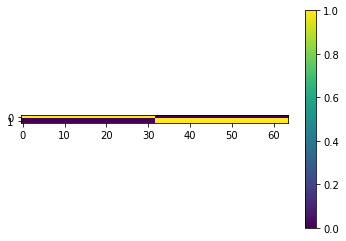

In [67]:
x,y,z = M.predict([v,a])
print(x)
print(y)
plt.imshow(z[0,0,0].T)
plt.colorbar()
plt.show()